# Heart Stroke Prediction

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

## Importing Dataset

In [24]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load directly from Kaggle 
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "fedesoriano/stroke-prediction-dataset",
    "healthcare-dataset-stroke-data.csv"  
)
print("First 5 records:", df.head())

df.to_csv('stroke_dataset.csv', index=False)

C:\Users\satya\AppData\Local\Temp\ipykernel_23204\2773647635.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:       id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


## Data Null Counts and Info

In [ ]:
data = pd.read_csv('stroke_dataset.csv')
print("Dataset shape:", data.shape)
print("\n=== Checking for Null Values ===")
print("Non-null count per column:")
print(data.isnull().count())  # This counts NON-NULL values
print("\nNull count per column:")
print(data.isnull().sum())    # This counts NULL values
print("\nTotal null values in dataset:", data.isnull().sum().sum())
print("\nInfo about the dataset:")
print(data.info())

Dataset shape: (5110, 12)

=== Checking for Null Values ===
Non-null count per column:
id                   5110
gender               5110
age                  5110
hypertension         5110
heart_disease        5110
ever_married         5110
work_type            5110
Residence_type       5110
avg_glucose_level    5110
bmi                  5110
smoking_status       5110
stroke               5110
dtype: int64

Null count per column:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Total null values in dataset: 201

Info about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             ------------

## Data Preprocessing

### Handling Missing Values

In [4]:
data['bmi'] = data['bmi'].fillna(data['bmi'].median())

### Convert categorical variables to numerical

In [5]:

data['gender'] = data['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
data['ever_married'] = data['ever_married'].map({'No': 0, 'Yes': 1})
data['work_type'] = data['work_type'].map({'children': 0, 'Govt_job': 1, 'Never_worked': 2, 'Private': 3, 'Self-employed': 4})
data['Residence_type'] = data['Residence_type'].map({'Rural': 0, 'Urban': 1})
data['smoking_status'] = data['smoking_status'].map({'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3})


### Split data into train and test sets

In [6]:
# Drop id column
data.drop('id', axis=1, inplace=True)


X = data.drop('stroke', axis=1)
y = data['stroke']


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Apply MinMax scaling

In [7]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Individual Model Training and Evaluation

### Initial Models

In [8]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "Naive Bayes": GaussianNB()
}


# Train and evaluate individual models
individual_accuracies = {}

for name, model in models.items():
    
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, predictions)
    individual_accuracies[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.9393
KNN Accuracy: 0.9374
Random Forest Accuracy: 0.9384
XGBoost Accuracy: 0.9393
Naive Bayes Accuracy: 0.8659


### Updated Models

In [9]:
updated_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', C=0.1),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights='distance'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced_subsample', max_depth=5),
    "XGBoost": XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), eval_metric='logloss'),
    "Naive Bayes": GaussianNB()
}


for name, model in updated_models.items():
    model.fit(X_train_scaled, y_train)

In [10]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_model(model, name, X_test, y_test):
    preds = model.predict(X_test)
    print(f"\n{name} Performance:")
    print(classification_report(y_test, preds))
    if hasattr(model, 'predict_proba'):
        print(f"ROC AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.4f}")
    return accuracy_score(y_test, preds)


# Evaluate all models
print("\n=== Detailed Model Evaluation ===")
individual_accuracies = {}
for name, model in updated_models.items():
    individual_accuracies[name] = evaluate_model(model, name, X_test_scaled, y_test)


=== Detailed Model Evaluation ===

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.98      0.74      0.85       960
           1       0.16      0.77      0.27        62

    accuracy                           0.74      1022
   macro avg       0.57      0.76      0.56      1022
weighted avg       0.93      0.74      0.81      1022

ROC AUC: 0.8527

KNN Performance:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.33      0.02      0.03        62

    accuracy                           0.94      1022
   macro avg       0.64      0.51      0.50      1022
weighted avg       0.90      0.94      0.91      1022

ROC AUC: 0.6713

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       960
           1       0.19      0.76      0.30        62

    accuracy                       


====Model Accuracies:=====
Logistic Regression: 0.7446
KNN: 0.9384
Random Forest: 0.7877
XGBoost: 0.9110
Naive Bayes: 0.8659


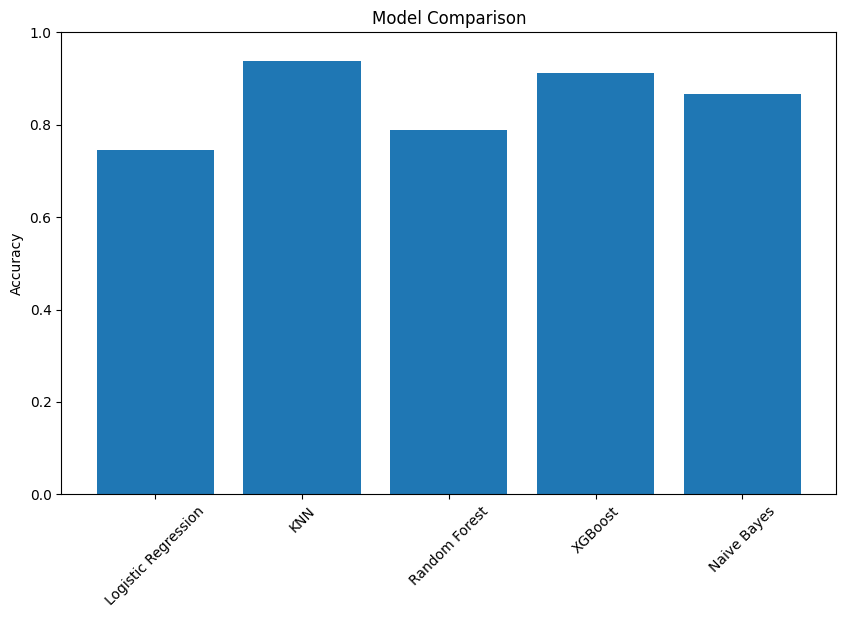

In [11]:

# Display all accuracies
print("\n====Model Accuracies:=====")
for name, accuracy in individual_accuracies.items():
    print(f"{name}: {accuracy:.4f}")


# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(individual_accuracies.keys(), individual_accuracies.values())
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
plt.show()

## Cross Checking and conclusions on the results and accuracies

In [17]:
print("Number of rows with No Stroke: data['stroke'] == 0 --->", (data['stroke']==0).sum())
print("Number of rows with Stroke : data['stroke'] == 1 --->", (data['stroke'] == 1).sum())


Number of rows with No Stroke: data['stroke'] == 0 ---> 4861
Number of rows with Stroke : data['stroke'] == 1 ---> 249


Even though the accuracy of some models is great, we cant tell that the model is working very well because the data it gets for the prediction may be of the **majority class**.

**So we cannot solely rely on the accuracy numbers of the models.**

We also have to check the **F1-score** and **Recall** of the model to conclude that a specific model is performig well.


That means accuracy alone is misleading — a model can predict mostly “0” and still be >90% accurate while failing on class 1.

Minority Class Performance (class 1) is critical here:
This is measured by recall (sensitivity) and precision for class 1.

| Model               | Accuracy | Recall (1) | Precision (1) | F1 (1)   | ROC AUC    |
| ------------------- | -------- | ---------- | ------------- | -------- | ---------- |
| Logistic Regression | 0.74     | **0.77**   | 0.16          | **0.27** | **0.8527** |
| KNN                 | 0.94     | 0.02       | 0.33          | 0.03     | 0.6713     |
| Random Forest       | 0.79     | **0.76**   | 0.19          | **0.30** | **0.8486** |
| XGBoost             | 0.91     | 0.19       | 0.23          | 0.21     | 0.7767     |
| Naive Bayes         | 0.87     | 0.48       | 0.22          | 0.30     | 0.8314     |



#### Logistic Regression & Random Forest Win

- Both have high recall (~0.76–0.77) → They catch most positives.

- Both have high ROC AUC (~0.85) → They separate classes well.

- Business value: In churn/fraud/medical detection, catching positives is priority — these models do that best.

Choice depends on tolerance for false positives:

- If you don’t mind many false alarms to catch almost every churner → Logistic Regression.

- If you want high recall but with slightly fewer false alarms → Random Forest.

## Final Model for Consideration

In [20]:
rfc = RandomForestClassifier(random_state=42, class_weight='balanced_subsample', max_depth=5)
rfc.fit(X_train_scaled, y_train)
predicts = rfc.predict(X_test_scaled)
print(accuracy_score(y_test,predicts))

0.7876712328767124


## Pickling of the model

In [21]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(rfc,f)
    
print("Model has been pickled and saved as 'model.pkl'")

Model has been pickled and saved as 'model.pkl'
